In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.8 MB 8.0 MB/s 
     |████████████████████████████████| 636 kB 38.1 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
import transformers
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)

## Load data

In [ ]:
#change to where you store mimic3 data
MIMIC_3_DIR = '/content/drive/MyDrive/Colab Notebooks/MSc-Individual-Project/datasets'

train_df = pd.read_csv('%s/train_10.csv' % MIMIC_3_DIR)
eval_df = pd.read_csv('%s/dev_10.csv' % MIMIC_3_DIR)
test_df = pd.read_csv('%s/test_10.csv' % MIMIC_3_DIR)

train_df.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,LABELS,length
0,17341,151110,Nursing/other,rsbi,584.9;427.31,1
1,61638,103816,Nursing,title,414.01,1
2,61638,103816,General,title,414.01,1
3,23706,186321,Nursing/other,npn,401.9;428.0;530.81,1
4,55265,191108,General,title,530.81;584.9;427.31,1


In [ ]:
full_df = pd.concat([train_df, eval_df, test_df], ignore_index=True)


 ## Preprocess Data

In [ ]:
# split labels by ";", then convert to list
def split_lab (x):
    #print(x)
    return x.split(";")

full_df['LABELS'] = full_df['LABELS'].apply(split_lab)
#full_df['TEXT'] = full_df['TEXT'].apply(split_lab)

full_df.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,LABELS,length
0,17341,151110,Nursing/other,rsbi,"[584.9, 427.31]",1
1,61638,103816,Nursing,title,[414.01],1
2,61638,103816,General,title,[414.01],1
3,23706,186321,Nursing/other,npn,"[401.9, 428.0, 530.81]",1
4,55265,191108,General,title,"[530.81, 584.9, 427.31]",1


In [ ]:
#load multi label binarizer for one-hot encoding
mlb = MultiLabelBinarizer(sparse_output=True)



In [ ]:
#change label to one-hot encoding per code
full_df = full_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(full_df.pop('LABELS')),
                columns=mlb.classes_))

full_df.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,length,250.00,272.4,401.9,414.01,427.31,428.0,518.81,530.81,584.9,599.0
0,17341,151110,Nursing/other,rsbi,1,0,0,0,0,1,0,0,0,1,0
1,61638,103816,Nursing,title,1,0,0,0,1,0,0,0,0,0,0
2,61638,103816,General,title,1,0,0,0,1,0,0,0,0,0,0
3,23706,186321,Nursing/other,npn,1,0,0,1,0,0,1,0,1,0,0
4,55265,191108,General,title,1,0,0,0,0,1,0,0,1,1,0


In [ ]:
# Convert columns to list of one hot encoding
icd_classes_50 = mlb.classes_

full_df['labels'] = full_df[icd_classes_50].values.tolist()
#train_df.sort_values(['length'], ascending=False, inplace=True)
full_df


,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,length,250.00,272.4,401.9,414.01,427.31,428.0,518.81,530.81,584.9,599.0,labels
0,17341,151110,Nursing/other,rsbi,1,0,0,0,0,1,0,0,0,1,0,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
1,61638,103816,Nursing,title,1,0,0,0,1,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,61638,103816,General,title,1,0,0,0,1,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,23706,186321,Nursing/other,npn,1,0,0,1,0,0,1,0,1,0,0,"[0, 0, 1, 0, 0, 1, 0, 1, 0, 0]"
4,55265,191108,General,title,1,0,0,0,0,1,0,0,1,1,0,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294460,97158,152158,Discharge summary,admission date discharge date date of birth se...,4644,0,0,1,0,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
294461,99650,199859,Discharge summary,admission date discharge date date of birth se...,5126,0,0,0,1,1,1,1,0,1,1,"[0, 0, 0, 1, 1, 1, 1, 0, 1, 1]"
294462,93623,187232,Discharge summary,admission date discharge date date of birth se...,5171,0,1,1,0,0,0,0,0,0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]"
294463,96260,110058,Discharge summary,admission date discharge date date of birth se...,5173,0,0,0,0,0,0,1,0,0,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]"


In [ ]:
full_df.HADM_ID.unique().shape

(9446,)

In [ ]:
full_df = full_df.drop(full_df[full_df['length']<300].index)

In [ ]:
train_df, test_df = train_test_split(full_df, test_size=0.2)
train_df, eval_df = train_test_split(train_df, test_size=0.2)

In [ ]:
train_df.sort_values(['length'], inplace=True)
eval_df.sort_values(['length'], inplace=True)
test_df.sort_values(['length'], inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_df = train_df.drop(train_df[train_df['CATEGORY']!='Physician '].index)
eval_df = eval_df.drop(eval_df[eval_df['CATEGORY']!='Physician '].index)
test_df = test_df.drop(test_df[test_df['CATEGORY']!='Physician '].index)

In [ ]:
train_df

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,length,250.00,272.4,401.9,414.01,427.31,428.0,518.81,530.81,584.9,599.0,labels
155062,42885,108950,Physician,chief complaint dyspnea hour events palliative...,300,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
276335,94414,170244,Physician,chief complaint hour events no overnight issue...,300,0,0,1,0,0,1,1,0,1,0,"[0, 0, 1, 0, 0, 1, 1, 0, 1, 0]"
276343,97022,153590,Physician,chief complaint hour events sbp has been in 90...,300,0,1,1,1,0,1,0,0,0,1,"[0, 1, 1, 1, 0, 1, 0, 0, 0, 1]"
276312,98494,114109,Physician,sicu hpi year old female with history of fistu...,300,0,0,0,1,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
155206,52631,184214,Physician,chief complaint hour events dialysis catheter ...,300,0,1,0,0,0,1,0,0,0,0,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248179,88514,193912,Physician,doctor first name bjbj p p bq pppp i8 j25 pmns...,2650,1,1,1,0,0,0,0,0,1,0,"[1, 1, 1, 0, 0, 0, 0, 0, 1, 0]"
206988,55265,191108,Physician,sicu hpi hpi year old male s p unrestrained pa...,2749,0,0,0,0,1,0,0,1,1,0,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]"
206990,55265,191108,Physician,sicu hpi hpi year old male s p unrestrained pa...,2749,0,0,0,0,1,0,0,1,1,0,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]"
207002,8670,113090,Physician,chief complaint hypoxia non perfused right leg...,2757,0,1,1,0,0,1,0,0,0,0,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 0]"


In [ ]:
train_df.HADM_ID.unique().shape

(2072,)

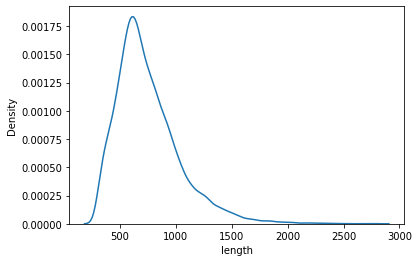

In [ ]:
sns.kdeplot(train_df.length)

In [ ]:
#convert into 2 columns dataframe
train_df = pd.DataFrame(train_df, columns=['TEXT', 'labels'])
train_df.columns=['text', 'labels']
train_df.head()

eval_df = pd.DataFrame(eval_df, columns=['TEXT', 'labels'])
eval_df.columns=['text', 'labels']
eval_df.head()

test_df = pd.DataFrame(test_df, columns=['HADM_ID', 'TEXT', 'labels'])
test_df.columns=['id', 'text', 'labels']


In [ ]:
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.head()

,id,text,labels
0,134661,chief complaint hpi hour events invasive venti...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,158722,chief complaint hour events overnight events a...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]"
2,165135,chief complaint hypoxia hour events bubble stu...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,107710,chief complaint hour events code purple called...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,193479,chief complaint hour events arterial line star...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


### Set Model Parameters

In [ ]:
# Defining some key variables to configure model training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 12
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 3e-05

#set tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

### Preparing Dataloader

In [ ]:
#custom dataset for BERT class
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        
        '''
            set text as training data
            set labels as targets
        '''
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
#load df to dataset

training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_set = CustomDataset(eval_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [ ]:
#data loader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False
                }

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

### Create model class from pretrained model

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        self.l1 = transformers.AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", return_dict=False)
        #self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        
        
        self.l2 = torch.nn.Dropout(0.3)
        

        self.l3 = torch.nn.Linear(768, 10)
    
    def forward(self, ids, mask, token_type_ids):
#        print("ids: ", ids.size(), "mask: ", mask.size(), "token type ids: ", token_type_ids.size())
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
#loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
#optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

### Train fine-tuning model

In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

In [ ]:
# Evaluate the model

def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    print(f'Epoch: {epoch}, Validation Loss:  {np.mean(losses):.2f}')
    return fin_outputs, fin_targets, losses

In [ ]:
start_epoch=0
DIR = '/content/drive/MyDrive/Colab Notebooks/MSc-Individual-Project/'
resume = True     
if resume:
    if os.path.isfile(f"%s/models/models_phys_epoch{start_epoch}.pth" % DIR):
        print("Resume from checkpoint...")
        checkpoint = torch.load(f"%s/models/models_phys_epoch{start_epoch}.pth" % DIR)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        initepoch = checkpoint['epoch']
        print("====>loaded checkpoint (epoch{})".format(checkpoint['epoch']))
    else:
        print("====>no checkpoint found.")
        initepoch = 0

for epoch in tqdm(range(EPOCHS)):
    train(epoch)
    validation(epoch)

    if (epoch+start_epoch+1) >3:
        checkpoint = {"model_state_dict": model.state_dict(),
                      "optimizer_state_dict": optimizer.state_dict(),
                      "epoch": epoch+start_epoch+1}
        path_checkpoint = f"%s/models/models_phys_epoch{epoch+start_epoch+1}.pth" % DIR
        torch.save(checkpoint, path_checkpoint)



====>no checkpoint found.


  0%|          | 0/5 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Training Loss:  0.9104873538017273


 20%|██        | 1/5 [44:45<2:59:01, 2685.26s/it]

Epoch: 0, Validation Loss:  0.46
Epoch: 1, Training Loss:  0.6160526275634766


 40%|████      | 2/5 [1:30:21<2:15:45, 2715.21s/it]

Epoch: 1, Validation Loss:  0.34
Epoch: 2, Training Loss:  0.2198517620563507


 60%|██████    | 3/5 [2:15:35<1:30:29, 2714.70s/it]

Epoch: 2, Validation Loss:  0.26
Epoch: 3, Training Loss:  0.2003985196352005
Epoch: 3, Validation Loss:  0.21


 80%|████████  | 4/5 [3:00:54<45:16, 2716.28s/it]  

Epoch: 4, Training Loss:  0.04675944522023201
Epoch: 4, Validation Loss:  0.17


100%|██████████| 5/5 [3:46:00<00:00, 2712.19s/it]


In [ ]:

DIR = '/content/drive/MyDrive/Colab Notebooks/MSc-Individual-Project/'

checkpoint = torch.load(f"%s/models/models_phys_epoch4.pth" % DIR)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>


### Model Evaluation

In [ ]:
# Evaluate the model

def evaluation():
    model.eval()

    fin_targets=[]
    fin_outputs=[]
    losses=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            fin_targets.extend(targets.cpu().detach().numpy())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy())
    print(f'Loss:  {np.mean(losses):.2f}')
    return fin_outputs, fin_targets, losses

In [ ]:
dev_out, dev_tar, losses = evaluation()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Loss:  0.06


In [ ]:
# Evaluate the model
def testing():
    model.eval()

    fin_targets=[]
    fin_outputs=[]
    losses=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            fin_targets.extend(targets.cpu().detach().numpy())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy())
    print(f'Loss:  {np.mean(losses):.2f}')

    return fin_outputs, fin_targets, losses

In [ ]:

test_out, targets, losses = testing()
outputs = np.array(test_out) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Loss:  0.15
F1 Score (Micro) = 0.9089875127360614
F1 Score (Macro) = 0.909342644667408


In [ ]:
ruc_auc_score_micro = metrics.roc_auc_score(targets, outputs, average='micro')
ruc_auc_score_macro = metrics.roc_auc_score(targets, outputs, average='macro')

print(f"RUC AUC Score (Micro) = {ruc_auc_score_micro}")
print(f"RUC AUC Score (Macro) = {ruc_auc_score_macro}")

RUC AUC Score (Micro) = 0.9442939739578697
RUC AUC Score (Macro) = 0.9367450600921435


In [ ]:
print(classification_report(targets, outputs, target_names=icd_classes_50, digits=4))

              precision    recall  f1-score   support

      250.00     0.9226    0.8922    0.9071      1549
       272.4     0.7964    0.9487    0.8659      1521
       401.9     0.9436    0.9298    0.9366      2734
      414.01     0.8888    0.9659    0.9258      1614
      427.31     0.8529    0.9779    0.9111      2307
       428.0     0.9311    0.9436    0.9373      2233
      518.81     0.7980    0.9878    0.8828      3276
      530.81     0.9634    0.8780    0.9187      1139
       584.9     0.8671    0.9574    0.9100      2535
       599.0     0.9396    0.8600    0.8981      1429

   micro avg     0.8772    0.9432    0.9090     20337
   macro avg     0.8903    0.9341    0.9093     20337
weighted avg     0.8828    0.9432    0.9097     20337
 samples avg     0.8863    0.9400    0.8996     20337



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_df['prediction'] = test_out
test_df['tar'] = targets

In [ ]:
test_df

,id,text,labels,prediction,tar
0,134661,chief complaint hpi hour events invasive venti...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.017446352, 0.005460005, 0.16749617, 0.06559...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,158722,chief complaint hour events overnight events a...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]","[0.015231338, 0.3744883, 0.155756, 0.010374857...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ..."
2,165135,chief complaint hypoxia hour events bubble stu...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0.00038405004, 0.08037745, 0.20208141, 0.1227...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,107710,chief complaint hour events code purple called...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0.0067919423, 0.005836662, 0.0023102225, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,193479,chief complaint hour events arterial line star...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0.0012171488, 0.00034943543, 0.002434801, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
6949,197571,sicu hpi hpi yo male restrained driver in a he...,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 1]","[0.60995257, 0.010348326, 0.99273187, 0.004824...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
6950,125407,title chief complaint hearing loss confusion h...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0]","[0.00086363463, 0.9854482, 0.048229184, 0.0239...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
6951,191108,sicu hpi hpi year old male s p unrestrained pa...,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]","[0.0036543524, 0.009082694, 0.006417939, 0.013...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
6952,168029,chief complaint s p fall and point hct drop hp...,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1]","[0.08404263, 0.995747, 0.7868571, 0.99282235, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."


In [ ]:
note_count_dict = test_df.groupby('id').size().to_dict()
test_df['note_count'] = test_df['id'].map(note_count_dict)

In [ ]:
test_df['out_bool'] = [(test_df['prediction'][i]>=0.5).astype(int) for i in test_df.index]

In [ ]:
out_freq_dict = test_df.groupby('id').out_bool.apply(np.sum).to_dict()
test_df['num_pred'] = test_df['id'].map(out_freq_dict)
test_df['num_pred'] = [(test_df['num_pred'][i]>=0.4*test_df['note_count'][i]).astype(int) for i in test_df.index]

In [ ]:
df_freq = test_df.drop_duplicates('id')

In [ ]:
out_freq = np.vstack([df_freq['num_pred'][i] for i in df_freq.index])
targets = np.vstack([df_freq['tar'][i] for i in df_freq.index])

#targets = dev_tar
accuracy = metrics.accuracy_score(targets, out_freq)
f1_score_micro = metrics.f1_score(targets, out_freq, average='micro')
f1_score_macro = metrics.f1_score(targets, out_freq, average='macro')

print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

F1 Score (Micro) = 0.8525413093495086
F1 Score (Macro) = 0.8544741625544312


In [ ]:
print(classification_report(targets, out_freq, target_names=icd_classes_50, digits=4))

              precision    recall  f1-score   support

      250.00     0.8778    0.8536    0.8655       362
       272.4     0.7279    0.9545    0.8260       440
       401.9     0.9239    0.9264    0.9251       747
      414.01     0.8348    0.9600    0.8930       400
      427.31     0.7372    0.9876    0.8442       483
       428.0     0.8810    0.9347    0.9070       475
      518.81     0.5457    0.9951    0.7049       408
      530.81     0.9365    0.8459    0.8889       279
       584.9     0.7386    0.9536    0.8324       474
       599.0     0.8858    0.8312    0.8576       308

   micro avg     0.7860    0.9314    0.8525      4376
   macro avg     0.8089    0.9243    0.8545      4376
weighted avg     0.8098    0.9314    0.8588      4376
 samples avg     0.8103    0.9327    0.8477      4376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ruc_auc_score_micro = metrics.roc_auc_score(targets, out_freq, average='micro')
ruc_auc_score_macro = metrics.roc_auc_score(targets, out_freq, average='macro')

print(f"RUC AUC Score (Micro) = {ruc_auc_score_micro}")
print(f"RUC AUC Score (Macro) = {ruc_auc_score_macro}")

RUC AUC Score (Micro) = 0.9196027920890809
RUC AUC Score (Macro) = 0.9153606380905611


In [ ]:
out_mean_dict = test_df.groupby('id').prediction.apply(np.mean).to_dict()
test_df['out_mean'] = test_df['id'].map(out_mean_dict)
test_df

,id,text,labels,prediction,tar,note_count,out_bool,num_pred,out_mean
0,134661,chief complaint hpi hour events invasive venti...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.017446352, 0.005460005, 0.16749617, 0.06559...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",20,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.0047250963, 0.018439578, 0.030872088, 0.025..."
1,158722,chief complaint hour events overnight events a...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]","[0.015231338, 0.3744883, 0.155756, 0.010374857...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",33,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]","[0.03222099, 0.19008042, 0.07273393, 0.0841159..."
2,165135,chief complaint hypoxia hour events bubble stu...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0.00038405004, 0.08037745, 0.20208141, 0.1227...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",5,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[0.0009696415, 0.02745289, 0.04847812, 0.03622..."
3,107710,chief complaint hour events code purple called...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0.0067919423, 0.005836662, 0.0023102225, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",9,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0.010352912, 0.0122551825, 0.021769729, 0.008..."
4,193479,chief complaint hour events arterial line star...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0.0012171488, 0.00034943543, 0.002434801, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.001101893, 0.0020639244, 0.2993892, 0.33656..."
...,...,...,...,...,...,...,...,...,...
6949,197571,sicu hpi hpi yo male restrained driver in a he...,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 1]","[0.60995257, 0.010348326, 0.99273187, 0.004824...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",14,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 1]","[1, 0, 1, 0, 0, 0, 1, 0, 0, 1]","[0.9672747, 0.015037988, 0.9958635, 0.00641029..."
6950,125407,title chief complaint hearing loss confusion h...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0]","[0.00086363463, 0.9854482, 0.048229184, 0.0239...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",5,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0]","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0]","[0.001130352, 0.9571196, 0.040002696, 0.021503..."
6951,191108,sicu hpi hpi year old male s p unrestrained pa...,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]","[0.0036543524, 0.009082694, 0.006417939, 0.013...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",14,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]","[0.007884428, 0.008599862, 0.0064291977, 0.013..."
6952,168029,chief complaint s p fall and point hct drop hp...,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1]","[0.08404263, 0.995747, 0.7868571, 0.99282235, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",3,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1]","[0, 1, 1, 1, 0, 1, 0, 0, 1, 0]","[0.16852796, 0.7900505, 0.9073885, 0.9885382, ..."


In [ ]:
df_mean = test_df.drop_duplicates('id')

In [ ]:
out_mean = np.vstack([df_mean['out_mean'][i]>=0.5 for i in df_mean.index])
targets = np.vstack([df_mean['tar'][i] for i in df_mean.index])
#targets = dev_tar
accuracy = metrics.accuracy_score(targets, out_mean)
f1_score_micro = metrics.f1_score(targets, out_mean, average='micro')
f1_score_macro = metrics.f1_score(targets, out_mean, average='macro')

print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

F1 Score (Micro) = 0.8696213425129089
F1 Score (Macro) = 0.8696119871228893


In [ ]:
print(classification_report(targets, out_mean, target_names=icd_classes_50, digits=4))

              precision    recall  f1-score   support

      250.00     0.9048    0.8398    0.8711       362
       272.4     0.7849    0.9455    0.8577       440
       401.9     0.9332    0.9157    0.9243       747
      414.01     0.8741    0.9550    0.9128       400
      427.31     0.7741    0.9793    0.8647       483
       428.0     0.9030    0.9411    0.9216       475
      518.81     0.5844    0.9926    0.7357       408
      530.81     0.9502    0.8208    0.8808       279
       584.9     0.7909    0.9494    0.8629       474
       599.0     0.9164    0.8182    0.8645       308

   micro avg     0.8215    0.9237    0.8696      4376
   macro avg     0.8416    0.9157    0.8696      4376
weighted avg     0.8417    0.9237    0.8741      4376
 samples avg     0.8409    0.9254    0.8647      4376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ruc_auc_score_micro = metrics.roc_auc_score(targets, out_mean, average='micro')
ruc_auc_score_macro = metrics.roc_auc_score(targets, out_mean, average='macro')

print(f"RUC AUC Score (Micro) = {ruc_auc_score_micro}")
print(f"RUC AUC Score (Macro) = {ruc_auc_score_macro}")

RUC AUC Score (Micro) = 0.9253573209240485
RUC AUC Score (Macro) = 0.9208105124752531
